In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import integrate

# set a custom figure style (this is optional, you can comment on this whole block)
import matplotlib as mpl
mpl.style.use('fivethirtyeight')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.edgecolor'] = 'white'
mpl.rcParams['font.family'] = 'Myriad Pro'

In [2]:
data = pd.read_csv('GRR997synthinput.csv', delimiter=',', names=['lambda', 'a_axis', 'b_axis', 'c_axis'])
data

,lambda,a_axis,b_axis,c_axis
0,1100.19,0.022589,0.056694,0.023680
1,1101.15,0.029813,-0.010129,0.073400
2,1102.12,0.042242,0.039765,0.114789
3,1103.08,0.152352,0.118840,0.130725
4,1104.05,0.213039,0.153203,0.148731
...,...,...,...,...
3003,3995.78,-0.000334,-0.000040,0.001882
3004,3996.75,0.000137,-0.000497,0.000862
3005,3997.71,0.000000,0.000000,0.000000
3006,3998.68,0.000000,0.000000,0.000000


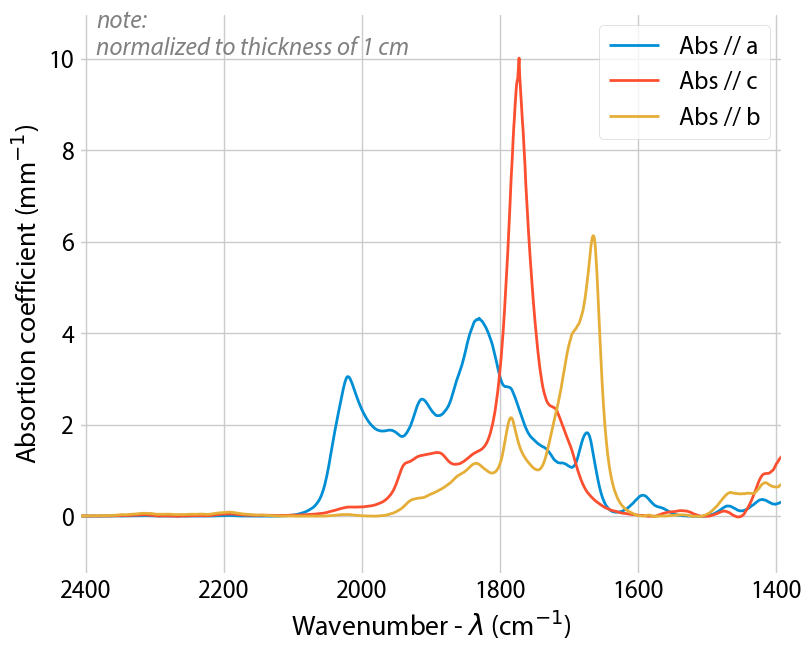

In [3]:
# make figure
fig, ax = plt.subplots(figsize=(8, 8*0.8), constrained_layout=True)

ax.plot(data['lambda'], data['a_axis'], linewidth=2, label=r'Abs // a')
ax.plot(data['lambda'], data['c_axis'], linewidth=2, label=r'Abs // c')
ax.plot(data['lambda'], data['b_axis'], linewidth=2, label=r'Abs // b')
ax.set_xlabel('Wavenumber - $\lambda$ (cm$^{-1}$)', fontsize=20)
ax.set_ylabel('Absortion coefficient (mm$^{-1}$)', fontsize=20)

# invert x axis
plt.gca().invert_xaxis()

# set custom x- and y-axis limits
ax.set_xlim(left=2410, right=1390)
ax.set_ylim(top=11)

# annotate
ax.text(x=2385, y=10.1, s='note:\nnormalized to thickness of 1 cm', fontsize=18, color='gray', fontstyle='italic')

ax.legend(loc='best', fontsize=18)
ax.tick_params(axis='both', labelsize=18)

The unpolarized absorbance according to Libowitzky and Rossman (1996) is

$$
A_{unpol} = -log_{10} \left( \frac{10^{-A_a} + 10^{-A_c}}{2} \right)
$$

> Eq. 11 in Withers (2013)

In [4]:
data['A_unpol'] = - np.log10((10**-data['a_axis'] + 10**-data['c_axis']) / 2)
data

,lambda,a_axis,b_axis,c_axis,A_unpol
0,1100.19,0.022589,0.056694,0.023680,0.023134
1,1101.15,0.029813,-0.010129,0.073400,0.051060
2,1102.12,0.042242,0.039765,0.114789,0.077003
3,1103.08,0.152352,0.118840,0.130725,0.141404
4,1104.05,0.213039,0.153203,0.148731,0.179696
...,...,...,...,...,...
3003,3995.78,-0.000334,-0.000040,0.001882,0.000773
3004,3996.75,0.000137,-0.000497,0.000862,0.000500
3005,3997.71,0.000000,0.000000,0.000000,-0.000000
3006,3998.68,0.000000,0.000000,0.000000,-0.000000


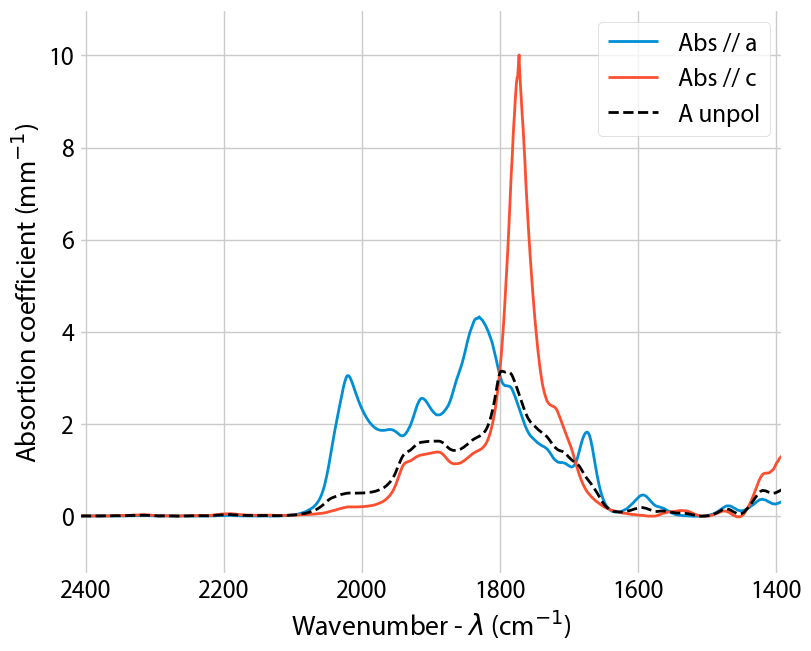

In [5]:
# make figure
fig, ax = plt.subplots(figsize=(8, 8*0.8), constrained_layout=True)

ax.plot(data['lambda'], data['a_axis'], linewidth=2, label=r'Abs // a')
ax.plot(data['lambda'], data['c_axis'], linewidth=2, label=r'Abs // c')
ax.plot(data['lambda'], data['A_unpol'], '--', color='black', linewidth=2, label=r'A unpol')
ax.set_xlabel('Wavenumber - $\lambda$ (cm$^{-1}$)', fontsize=20)
ax.set_ylabel('Absortion coefficient (mm$^{-1}$)', fontsize=20)

# invert x axis
plt.gca().invert_xaxis()

# set custom x- and y-axis limits
ax.set_xlim(left=2410, right=1390)
ax.set_ylim(top=11)

ax.legend(loc='best', fontsize=18)
ax.tick_params(axis='both', labelsize=18)

The unpolarized absorbance according to Sambridge et al. (2008) is

$$
A_{unpol} = \frac{1}{2\pi} \int_{0}^{2\pi} A(\theta) d\theta
$$

where $A(\theta)$

$$
A(\theta) = -log_{10} \left( 10^{-A_a} cos^2\theta + 10^{-A_c} sin^2\theta  \right)
$$

> Eqs. 12 and 13 in Withers 2013 

In [6]:
# define the function to integrate
def f(theta, Aa, Ac):
    return -np.log10(10**-Aa * np.cos(theta)**2 + 10**-Ac * np.sin(theta)**2)

In [7]:
# TEST
# get some a-axis and c axis values for a especific lambda value (e.g. 1800.22 which is at index postion 726)
Aa = data.loc[726, 'a_axis']
Ac = data.loc[726, 'c_axis']

# fixed_quad compute a definite integral using fixed-order Gaussian quadrature. See https://docs.scipy.org/doc/scipy/reference/integrate.html
result, error = integrate.fixed_quad(f, 0, 2*np.pi, n=20, args=(Aa, Ac))

print("Result:", result / (2*np.pi))
print("Error:", error)

Result: 3.099371342523781
Error: None


In [8]:
# define the function to apply to the dataFrame row by row
def sambridge(data):
    result, _ = integrate.fixed_quad(f, 0, 2*np.pi, n=20, args=(data['a_axis'], data['c_axis']))
    return result / (2*np.pi)

# apply the sambridge approach to each row and store the results in a new column
data['A_unpol2'] = data.apply(lambda data: sambridge(data), axis=1)

In [9]:
data

,lambda,a_axis,b_axis,c_axis,A_unpol,A_unpol2
0,1100.19,0.022589,0.056694,0.023680,0.023134,2.313463e-02
1,1101.15,0.029813,-0.010129,0.073400,0.051060,5.133317e-02
2,1102.12,0.042242,0.039765,0.114789,0.077003,7.775841e-02
3,1103.08,0.152352,0.118840,0.130725,0.141404,1.414712e-01
4,1104.05,0.213039,0.153203,0.148731,0.179696,1.802900e-01
...,...,...,...,...,...,...
3003,3995.78,-0.000334,-0.000040,0.001882,0.000773,7.733674e-04
3004,3996.75,0.000137,-0.000497,0.000862,0.000500,4.996474e-04
3005,3997.71,0.000000,0.000000,0.000000,-0.000000,1.050032e-17
3006,3998.68,0.000000,0.000000,0.000000,-0.000000,1.050032e-17


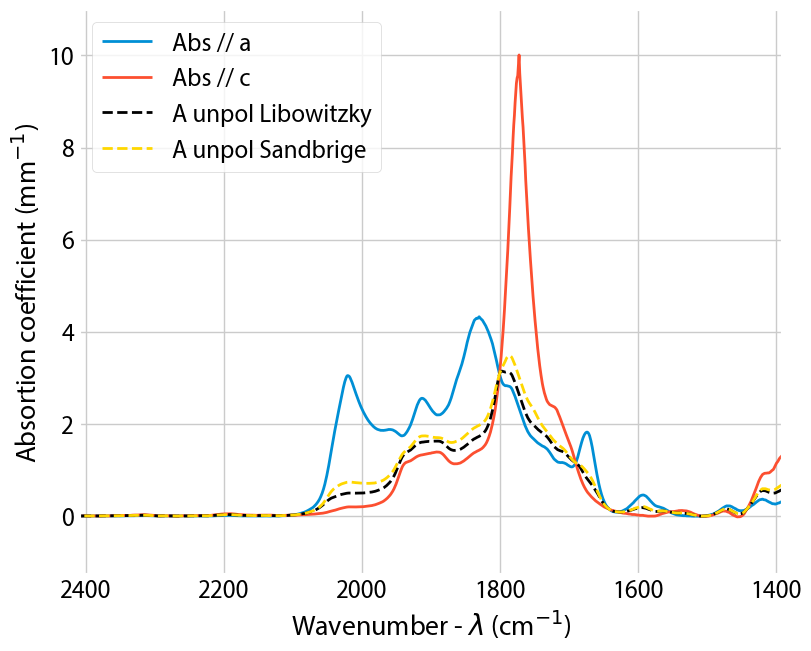

In [10]:
# make figure
fig, ax = plt.subplots(figsize=(8, 8*0.8), constrained_layout=True)

ax.plot(data['lambda'], data['a_axis'], linewidth=2, label=r'Abs // a')
ax.plot(data['lambda'], data['c_axis'], linewidth=2, label=r'Abs // c')
ax.plot(data['lambda'], data['A_unpol'], '--', color='black', linewidth=2, label=r'A unpol Libowitzky')
ax.plot(data['lambda'], data['A_unpol2'], '--', color='gold', linewidth=2, label=r'A unpol Sandbrige')
ax.set_xlabel('Wavenumber - $\lambda$ (cm$^{-1}$)', fontsize=20)
ax.set_ylabel('Absortion coefficient (mm$^{-1}$)', fontsize=20)

# invert x axis
plt.gca().invert_xaxis()

# set custom x- and y-axis limits
ax.set_xlim(left=2410, right=1390)
ax.set_ylim(top=11)

ax.legend(loc='best', fontsize=18)
ax.tick_params(axis='both', labelsize=18)

# Generalisation

> Aim: generalise the above procedure to any crystal orientation.

In [11]:
# import Scipy's rotation module
from scipy.spatial.transform import Rotation as r
mpl.style.use('default')

# define some functions
def Tvalues(trans, theta, phi):
    """ Calculates the transmission value for any direction in polar
    coordinates using the equation (5) of Asimov et al. (2006) for a
    especific wavelength ignoring the sample thickness (i.e. =1).

    Parameters
    ----------
    trans : a tuple of size 3
        tuple containeing the transmission values along a-axis (Ta),
        b-axis (Tb), and c-axis (Tc). -> (Ta, Tb, Tc)
    theta : int or float between 0 and pi/2
        angle respect to the c-axis in radians
    phi : int or float between 0 and 2*pi
        angle respect to the a-axis in radians

    Returns
    -------
    numpy array
        the calculated T values for any given orientation
    """

    # extract Tx values
    Ta, Tb, Tc = trans
    
    return Ta * np.cos(phi)**2 * np.sin(theta)**2 + \
           Tb * np.sin(phi)**2 * np.sin(theta)**2 + \
           Tc * np.cos(theta)**2


def sph2cart(r, phi, theta=np.deg2rad(90)):
    """ Convert from spherical/polar (magnitude, thetha, phi) to
    cartesian coordinates. Phi and theta angles are as used in
    physics (ISO 80000-2:2019) and in radians. If theta is not given,
    the point is assumed to lie on the XY plane.

    Parameters
    ----------
    r : int, float or array
        radial distance (magnitud of the vector)
    phi : int, float or array with values between 0 and 2*pi
        azimuth angle respect to the x-axis direction in radians
    theta : int, float or array with values between 0 and pi/2,
        polar angle respect to the zenith (z) direction in radians
        optional
    
    Returns
    -------
    numpy ndarrays (1d)
        three numpy 1d arrays with the cartesian x, y, and z coordinates
    """
    
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    
    return np.around(x, decimals=6), np.around(y, decimals=6), np.around(z, decimals=6)


def extract_XY_section(x, y, z):
    """ It uses the matplolib contour function to get the values
    and spherical coordinates of T values within the XY plane.
    plane. The contour function uses he marching squares algorithm
    to fing the intersection at a defined level.

    Parameters
    ----------
    x : _type_
        _description_
    y : _type_
        _description_
    z : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """

    # estimate the contour at z=0 (i.e. XY plane)
    section_xy = plt.contour(x, y, z, levels=[0]);

    # get the vertice coordinates (array-like)
    coordinates = section_xy.allsegs[0][0]

    # get vector lengths (i.e. T values within the XY plane)
    T = np.linalg.norm(coordinates, axis=1)

    # get the angle of the vector (in radians)
    angles = np.arctan2(coordinates[:, 1], coordinates[:, 0])

    # Convert angles to the range 0-2π (0-360 degrees)
    angles = np.degrees(angles) % 360

    # Convert angles to the range 0-360 degrees clockwise
    angles = (90 - angles) % 360

    df = pd.DataFrame({
        'x': coordinates[:, 0],
        'y': coordinates[:, 1],
        'T': T,
        'angles': angles
    })

    return df

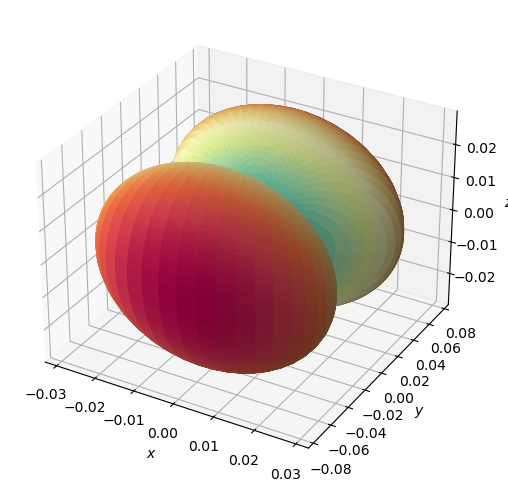

In [12]:
# generate spherical/polar coordinates
phi = np.linspace(0, 2*np.pi, 100)
theta = np.arccos(1 - 2 * np.linspace(0, 1, 100))  # phi = arcos(1 - 2x) in this case np.linspace goes from 0 to 1 (not pi)!*
theta, phi = np.meshgrid(theta, phi)

# estimate transmissión values for a especific lambda value (e.g. 1800.22 which is at index postion 726)
Aa = data.loc[726, 'a_axis']
Ab = data.loc[726, 'b_axis']
Ac = data.loc[726, 'c_axis']

# estimate T values
Ta = 1 / 10**Aa
Tb = 1 / 10**Ab
Tc = 1 / 10**Ac

# estimate T values for different crystal directions
T = Tvalues(trans=(Ta, Tb, Tc), theta=theta, phi=phi)

# convert from spherical to cartesian coordinates
x, y, z = sph2cart(T, phi, theta)

# normalize colors for T values to max and min values
Tmax, Tmin = T.max(), T.min()
Tcolors = (T - Tmin) / (Tmax - Tmin)

# make figure
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, constrained_layout=True)
ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=cm.Spectral_r(Tcolors))
_ = ax.set_xlabel(r'$x$'), ax.set_ylabel(r'$y$'), ax.set_zlabel(r'$z$')

,x,y,T,angles,A
0,0.000873,0.000000,0.000873,90.000000,3.058986
1,0.001167,0.000074,0.001169,86.371706,2.932058
2,0.002037,0.000260,0.002054,82.726173,2.687500
3,0.003447,0.000664,0.003510,79.096595,2.454647
4,0.005341,0.001386,0.005518,75.452515,2.258226
...,...,...,...,...,...
95,0.005341,-0.001386,0.005518,104.547485,2.258226
96,0.003447,-0.000664,0.003510,100.903405,2.454647
97,0.002037,-0.000260,0.002054,97.273827,2.687500
98,0.001167,-0.000074,0.001169,93.628294,2.932058


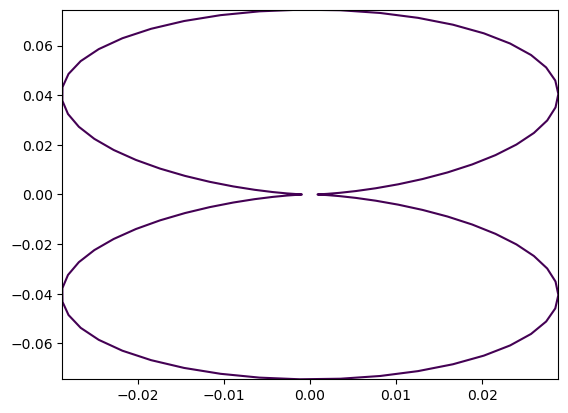

In [13]:
Ts = extract_XY_section(x, y, z)

Ts['A'] = -np.log10(Ts['T'])
Ts

In [14]:
# get the unpolarized absorbance according to Libowitzky and Rossman (1996)
np.around(-np.log10((10**-Ts['A'].max() + 10**-Ts['A'].min()) / 2), 3)

1.424

In [15]:
# define the function to apply the Sanbridge approach
# define the function to integrate
def f(theta, A_max, A_min):
    return -np.log10(10**-A_max * np.cos(theta)**2 + 10**-A_min * np.sin(theta)**2)

result, error = integrate.fixed_quad(f, 0, 2*np.pi, n=20, args=(Ts['A'].max(), Ts['A'].min()))

print(f"Result = {(result / (2*np.pi)):.3f}")
print("Error:", error)

Result = 1.626
Error: None


## Example with a rotation

In [16]:
def rotate(coordinates, euler_ang):
    """ Rotate points in 3D cartesian space using the Bunge convention
    in degrees with intrinsic rotation. This is just a wrapper for the
    r.from_euler() Scipy method for convenience

    Parameters
    ----------
    coordinates : tuple of size 3
        a tuple containing the cartesian coordinates of this form:
        (x, y, z). variables x, y and z can be scalars or arrays.
    euler_ang : tuple of size 3
        a tuple containing the three euler angles in degrees
        using Bunge convention -> (z, x, z)

    Returns
    -------
    three numpy arrays containing the x, y, z coordinates respectively
    
    Example
    -------
    x, y, z = rotate(coordinates=(x, y, z), euler_ang=(30, 0, 40))
    """
    # create a ndarray to vectorize the rotation operation
    coordinates = np.dstack(coordinates)

    # define a rotation in euler space (Bunge) for intrinsic rotations
    rotation = r.from_euler('zxz', [euler_ang[0], euler_ang[1], euler_ang[2]], degrees=True)

    # apply rotation
    new_coordinates = coordinates @ rotation.as_matrix().T

    return new_coordinates[:,:,0], new_coordinates[:,:,1], new_coordinates[:,:,2]

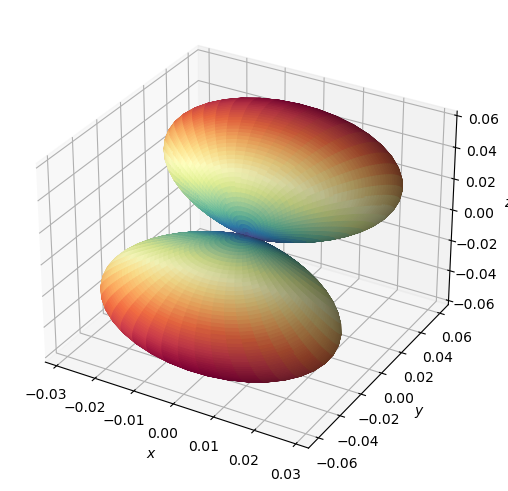

In [17]:
x_rot, y_rot, z_rot = rotate(coordinates=(x, y, z), euler_ang=(0, 45, 0))

# make figure
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, constrained_layout=True)
ax.plot_surface(x_rot, y_rot, z_rot, rstride=1, cstride=1, facecolors=cm.Spectral_r(Tcolors))
_ = ax.set_xlabel(r'$x$'), ax.set_ylabel(r'$y$'), ax.set_zlabel(r'$z$')

,x,y,T,angles,A
0,0.000873,0.000000,0.000873,90.000000,3.058986
1,0.000910,0.000013,0.000910,89.165063,3.040785
2,0.000990,0.000042,0.000991,87.579261,3.003889
3,0.001091,0.000078,0.001093,85.906440,2.961262
4,0.001163,0.000105,0.001168,84.858674,2.932623
...,...,...,...,...,...
235,0.001163,-0.000105,0.001168,95.141326,2.932623
236,0.001091,-0.000078,0.001093,94.093560,2.961262
237,0.000990,-0.000042,0.000991,92.420739,3.003889
238,0.000910,-0.000013,0.000910,90.834937,3.040785


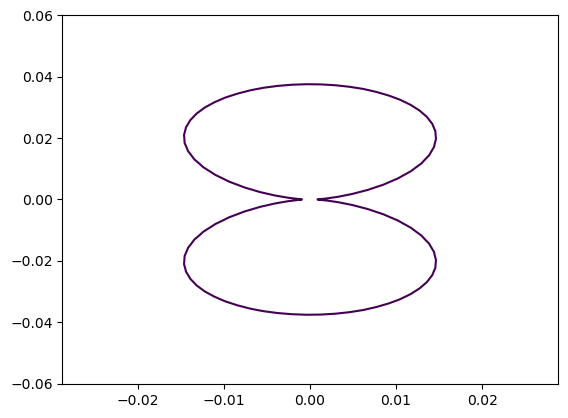

In [18]:
Ts_rot = extract_XY_section(x_rot, y_rot, z_rot)

Ts_rot['A'] = -np.log10(Ts_rot['T'])
Ts_rot

In [19]:
# get the unpolarized absorbance according to Libowitzky and Rossman (1996)
np.around(-np.log10((10**-Ts_rot['A'].max() + 10**-Ts_rot['A'].min()) / 2), 3)

1.716

In [20]:
# define the function to apply the Sanbridge approach
# define the function to integrate
def f(theta, A_max, A_min):
    return -np.log10(10**-A_max * np.cos(theta)**2 + 10**-A_min * np.sin(theta)**2)

result, error = integrate.fixed_quad(f, 0, 2*np.pi, n=20, args=(Ts_rot['A'].max(), Ts_rot['A'].min()))

print(f"Result = {(result / (2*np.pi)):.3f}")
print("Error:", error)

Result = 1.895
Error: None
